In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from collections import defaultdict

In [3]:
import numpy as np
from cluster_quality_metrics import (
    within_cluster_sum_of_squares,
    average_pairwise_similarity,
    inter_cluster_distance,
    overall_average_pairwise_similarity,
    plot_wcss,
    plot_cohesion,
    plot_separation
)

In [4]:

file_path = 'section_3.csv' 
with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
    df = pd.read_csv(f)

# Extract user IDs and text data
user_ids = df['Id']  
text_data1 = df['Please specify your broad areas of interest (keywords only) for the final project (e.g., games, reinforcement learning, computer vision, natural language processing, etc.) in ranked order of preferenc'] 
text_data2 = df['Do you already have one or more specific project ideas? If so, please briefly describe them.�']  # Replace with the actual name of the second text column
text_data2 = text_data2.fillna('')
# Combine the two text columns (you can concatenate them, or choose a different method)
combined_text = text_data1 + " " + text_data2



In [5]:
tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(combined_text)

# Step 3: Convert the sparse TF-IDF matrix to a NumPy array (optional if you need a dense representation for clustering)
embeddings = tfidf_matrix.toarray() 

In [6]:
print(embeddings) 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [7]:
embeddings[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.20433642, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [8]:
max_size = 4
initial_num_clusters = len(embeddings) // max_size

kmeans = KMeans(n_clusters=initial_num_clusters, random_state=0)
initial_labels = kmeans.fit_predict(embeddings)

cluster_dict = defaultdict(list)
for i, label in enumerate(initial_labels):
    cluster_dict[label].append(i)

In [9]:
# # Function to perform clustering and handle clusters larger than the max size
# def recluster_large_clusters(cluster_dict, embeddings, max_size=4):
#     final_clusters = []
    
#     for cluster_items in cluster_dict.values():
#         # If a cluster is larger than the max size, split it further using KMeans
#         if len(cluster_items) > max_size:
#             sub_embeddings = [embeddings[i] for i in cluster_items]
            
#             # Create a new KMeans model to split large clusters into smaller ones
#             sub_kmeans = KMeans(n_clusters=(len(cluster_items) // max_size) + 1, random_state=0)
#             sub_labels = sub_kmeans.fit_predict(sub_embeddings)
            
#             # Group the sub-clustered items
#             sub_cluster_dict = defaultdict(list)
#             for idx, sub_label in zip(cluster_items, sub_labels):
#                 sub_cluster_dict[sub_label].append(idx)
                
#             # Add the sub-clusters to the final list
#             for sub_cluster_items in sub_cluster_dict.values():
#                 final_clusters.append(sub_cluster_items)
#         else:
#             # If cluster size is within the limit, add it as-is
#             final_clusters.append(cluster_items)
    
#     return final_clusters

In [10]:
from sklearn.cluster import KMeans
from collections import defaultdict

# Function to perform clustering and handle clusters larger than the max size
def recluster_large_clusters(cluster_dict, embeddings, max_size=4):
    final_clusters = []
    
    for cluster_items in cluster_dict.values():
        # If a cluster is larger than the max size, split it further using KMeans
        if len(cluster_items) > max_size:
            # Get embeddings for items in this cluster
            sub_embeddings = [embeddings[i] for i in cluster_items]
            
            # Determine the number of sub-clusters needed
            n_sub_clusters = (len(cluster_items) // max_size) + 1
            
            # Create and fit KMeans to split the large cluster
            sub_kmeans = KMeans(n_clusters=n_sub_clusters, random_state=0)
            sub_labels = sub_kmeans.fit_predict(sub_embeddings)
            
            # Group items by sub-cluster label
            sub_cluster_dict = defaultdict(list)
            for idx, sub_label in zip(cluster_items, sub_labels):
                sub_cluster_dict[sub_label].append(idx)
                
            # Add each sub-cluster to final_clusters, ensuring they meet size requirements
            for sub_cluster_items in sub_cluster_dict.values():
                if len(sub_cluster_items) > max_size:
                    # Recursively split sub-clusters that still exceed max_size
                    split_sub_clusters = recluster_large_clusters({0: sub_cluster_items}, embeddings, max_size)
                    final_clusters.extend(split_sub_clusters)
                else:
                    final_clusters.append(sub_cluster_items)
        else:
            # If the cluster size is within the limit, add it as-is
            final_clusters.append(cluster_items)
    
    return final_clusters

In [11]:
# Function to combine clusters with fewer than 4 members
def combine_small_clusters(clusters, embeddings, max_size=4):
    # Identify clusters with fewer than 4 members
    small_clusters = [cluster for cluster in clusters if len(cluster) < max_size]
    remaining_clusters = [cluster for cluster in clusters if len(cluster) == max_size]

    combined = False  # Track if any clusters are combined
    new_clusters = remaining_clusters.copy()

    # For each small cluster, find the most similar cluster and merge
    for small_cluster in small_clusters:
        small_embeddings = np.mean([embeddings[i] for i in small_cluster], axis=0)

        # Find the nearest cluster that still has space to accommodate the small cluster
        min_distance = float('inf')
        nearest_cluster = None
        nearest_cluster_idx = -1
        for idx, cluster in enumerate(new_clusters):
            if len(cluster) < max_size:  # Only consider clusters with space
                cluster_embeddings = np.mean([embeddings[i] for i in cluster], axis=0)
                distance = euclidean_distances([small_embeddings], [cluster_embeddings])[0][0]
                if distance < min_distance:
                    min_distance = distance
                    nearest_cluster = cluster
                    nearest_cluster_idx = idx

        # Merge small cluster with the nearest cluster (but ensure combined cluster does not exceed 4 members)
        if nearest_cluster is not None and len(small_cluster) + len(nearest_cluster) <= max_size:
            new_clusters[nearest_cluster_idx].extend(small_cluster)
            combined = True
        else:
            # If no valid merge is found, leave the small cluster as a new independent cluster
            new_clusters.append(small_cluster)

    return new_clusters, combined

In [12]:
# Perform iterative clustering inside a loop
iteration_count = 0  # Add an iteration counter to prevent infinite loops
max_iterations = 50  # Set a maximum number of iterations to avoid infinite loops

while iteration_count < max_iterations:
    iteration_count += 1
    
    # Re-cluster large clusters
    new_clusters = recluster_large_clusters(cluster_dict, embeddings, max_size=max_size)

    # Combine small clusters with their nearest neighbors
    final_clusters, combined = combine_small_clusters(new_clusters, embeddings, max_size=max_size)

    # Debug: Print the sizes of all clusters after each iteration
    print(f"Iteration {iteration_count} cluster sizes: {[len(c) for c in final_clusters]}")
    
    # Check if all clusters are now size 4
    if all(len(cluster) == max_size for cluster in final_clusters):
        break  # Exit the loop if all clusters have exactly 4 members
    
    # If no changes were made, stop the loop to avoid infinite looping
    if not combined:
        print("No further changes detected, stopping iteration.")
        break

    # Update cluster_dict for the next iteration
    cluster_dict = defaultdict(list)
    for i, cluster in enumerate(final_clusters):
        for item in cluster:
            cluster_dict[i].append(item)

Iteration 1 cluster sizes: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 3, 2, 3, 2, 2]
Iteration 2 cluster sizes: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 2, 3, 2, 2]
No further changes detected, stopping iteration.


In [13]:
# Flatten the clusters and assign final labels
final_cluster_labels = np.zeros(len(combined_text), dtype=int)

# **Fix for Label Assignment**
# Ensure that each cluster gets a unique ID and all points are labeled correctly
for cluster_id, cluster_items in enumerate(final_clusters):
    for item in cluster_items:
        final_cluster_labels[item] = cluster_id

In [14]:
# Assign the final cluster labels and save to CSV
df['cluster'] = final_cluster_labels
df_sorted = df.sort_values(by='cluster')
df_sorted.to_csv('result_3/final_tf-idf_Kmeans_clusters.csv', index=False)

print("Clustering using Word2Vec completed and saved to final_word2vec_clusters.csv")

Clustering using Word2Vec completed and saved to final_word2vec_clusters.csv


WCSS per cluster: {0: 2.633651653786993, 1: 0.274743866469682, 2: 0.7308974089721731, 3: 0.09974660349073809, 4: 1.0756084332177875, 5: 1.2979742074958978, 6: 2.125163625456465, 7: 1.6645619253855033, 8: 1.3634451740130809, 9: 2.1920851374419628, 10: 2.249995001482897, 11: 2.7373218111773814, 12: 1.789176094762695, 13: 2.7205249127321727, 14: 1.253276763359666, 15: 1.598440969772199, 16: 2.617607739825495, 17: 2.6206418986093896, 18: 2.789254758726858, 19: 2.5892650387663796, 20: 2.6538010711800877, 21: 2.666567040883818, 22: 1.1225313926635738, 23: 0.9753688278904731, 24: 0.49518878511909004, 25: 1.267786815355314, 26: 0.8511962165296078, 27: 0.14599374703667775}


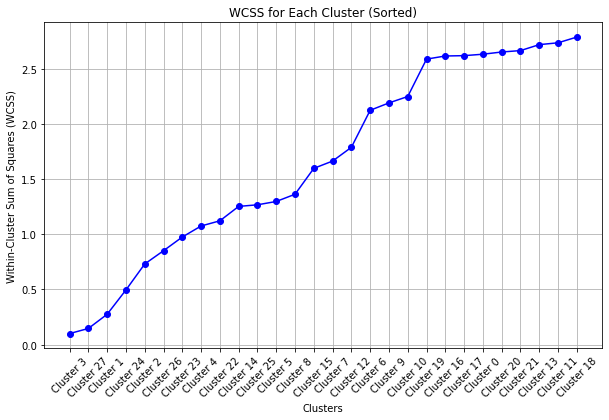

Cohesion per cluster: {0: 0.12211611540433571, 1: 0.9084187111767726, 2: 0.756367530342609, 3: 0.9667511321697543, 4: 0.6414638555940709, 5: 0.5673419308347009, 6: 0.29161212484784504, 7: 0.44514602487149907, 8: 0.545518275328973, 9: 0.26930495418601225, 10: 0.2500016661723676, 11: 0.08755939627420627, 12: 0.4036079684124349, 13: 0.0931583624226089, 14: 0.5822410788801113, 15: 0.46718634340926707, 16: 0.12746408672483484, 17: 0.12645270046353665, 18: 0.07024841375771416, 19: 0.1369116537445399, 20: 0.11539964293997074, 21: 0.11114431970539418, 22: 0.43873430366821303, 23: 0.5123155860547638, 24: 0.50481121488091, 25: 0.36610659232234305, 26: 0.14880378347039233, 27: 0.8540062529633223}


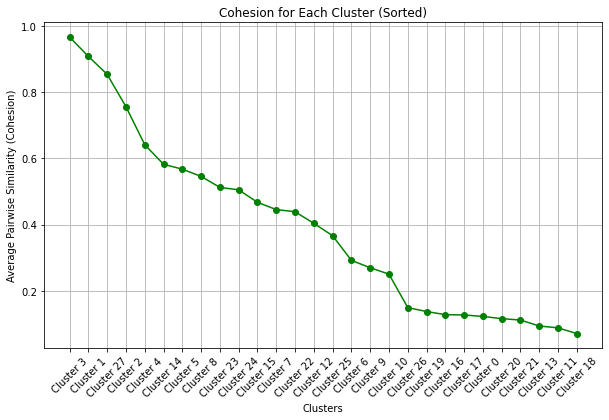

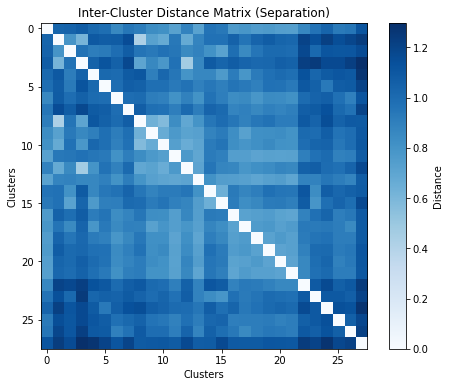

Overall Average Pairwise Similarity: 0.3748026973849441


In [16]:
embeddings_np = np.array(embeddings)
# Calculate WCSS and plot
wcss_per_cluster = within_cluster_sum_of_squares(embeddings_np, final_clusters)
print("WCSS per cluster:", wcss_per_cluster)
plot_wcss(wcss_per_cluster)


# Calculate Cohesion and plot
cohesion_per_cluster = average_pairwise_similarity(embeddings, final_clusters)
print("Cohesion per cluster:", cohesion_per_cluster)
plot_cohesion(cohesion_per_cluster)

# Calculate Inter-Cluster Distance (Separation) and plot
separation_matrix = inter_cluster_distance(embeddings, final_clusters)
# print("Inter-Cluster Distance Matrix:\n", separation_matrix)
plot_separation(separation_matrix)

# Calculate Overall Average Pairwise Similarity
overall_similarity = overall_average_pairwise_similarity(embeddings, final_clusters)
print("Overall Average Pairwise Similarity:", overall_similarity)

**Using FAISS from here on**

In [17]:
import faiss

In [18]:
max_size = 4

# Function to perform clustering using Faiss and explicitly merge small clusters
def faiss_clustering_with_merging(embeddings, max_size=4):
    """
    Perform clustering using Faiss and actively merge small clusters.
    Args:
        embeddings: List of sentence embeddings.
        max_size: Maximum size of each cluster.
    Returns:
        List of clusters with merged small clusters.
    """
    n_samples = len(embeddings)
    embedding_dim = len(embeddings[0])  # Dimensionality of embeddings

    # Build Faiss index
    index = faiss.IndexFlatL2(embedding_dim)  # Using L2 (Euclidean distance)
    index.add(np.array(embeddings))  # Add all embeddings to the index

    # Find clusters using nearest neighbors
    visited = set()
    clusters = []

    for i in range(n_samples):
        if i not in visited:
            # Query nearest neighbors
            distances, neighbors = index.search(np.array([embeddings[i]]), max_size)
            neighbors = neighbors.flatten()
            # Only take unvisited neighbors
            cluster = [n for n in neighbors if n not in visited]
            clusters.append(cluster)
            visited.update(cluster)

    # Step 2: Actively merge small clusters with each other
    final_clusters = []
    small_clusters = [c for c in clusters if len(c) < max_size]
    full_clusters = [c for c in clusters if len(c) == max_size]

    while small_clusters:
        current_cluster = small_clusters.pop(0)

        # Try to merge the current small cluster with another small cluster
        merged = False
        for other_cluster in small_clusters:
            if len(current_cluster) + len(other_cluster) <= max_size:
                current_cluster.extend(other_cluster)
                small_clusters.remove(other_cluster)  # Remove the merged cluster
                merged = True
                break

        # If merged successfully or couldn't be merged further, add it to final clusters
        if len(current_cluster) <= max_size:
            final_clusters.append(current_cluster)
        else:
            # If merging exceeded the size limit, split and handle separately
            final_clusters.append(current_cluster[:max_size])
            remaining_part = current_cluster[max_size:]
            small_clusters.insert(0, remaining_part)  # Re-add remaining part as a new cluster

    final_clusters.extend(full_clusters)  # Add the already full clusters

    return final_clusters

In [19]:
# Perform clustering using Faiss with active merging
clusters = faiss_clustering_with_merging(embeddings, max_size=max_size)

# Debug: Print cluster sizes
print(f"Generated {len(clusters)} clusters. Cluster sizes: {[len(c) for c in clusters]}")

# Assign cluster labels to the DataFrame
final_cluster_labels = np.zeros(len(combined_text), dtype=int)

for cluster_id, cluster_items in enumerate(clusters):
    for item in cluster_items:
        final_cluster_labels[item] = cluster_id

# Add the new cluster labels to the DataFrame
df['cluster'] = final_cluster_labels

# Sort the DataFrame by cluster labels
df_sorted = df.sort_values(by='cluster')

# Save the sorted DataFrame to a new CSV file
df_sorted.to_csv('result_3/faiss_tf-idf.csv', index=False)

print("Clustering completed with active merging and saved to faiss_clustered_data_with_merging.csv")


Generated 31 clusters. Cluster sizes: [3, 4, 4, 4, 4, 4, 4, 3, 2, 3, 2, 3, 2, 3, 3, 2, 2, 3, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Clustering completed with active merging and saved to faiss_clustered_data_with_merging.csv


WCSS per cluster: {0: 1.6139326189197518, 1: 2.5269513760083653, 2: 2.5259859616058917, 3: 2.5093687749743694, 4: 2.6504262103034764, 5: 2.3300924107064587, 6: 2.128078852870427, 7: 1.559112961562462, 8: 0.9201242866520115, 9: 1.5608994600235, 10: 0.9659077550291281, 11: 1.8325216456507842, 12: 0.9999999999999998, 13: 1.6858783098311272, 14: 1.7979839196649248, 15: 0.9796404245482797, 16: 0.8683588517779574, 17: 1.407479902482613, 18: 1.802530964756212, 19: 0.0, 20: 2.0362657699654334, 21: 0.7132605488103276, 22: 0.5213919720580116, 23: 0.10264615961383225, 24: 2.5334477250488687, 25: 2.5419634392822568, 26: 1.0756084332177873, 27: 1.2979742074958978, 28: 2.2558911103604915, 29: 2.253333282075485, 30: 2.5234079368394435}


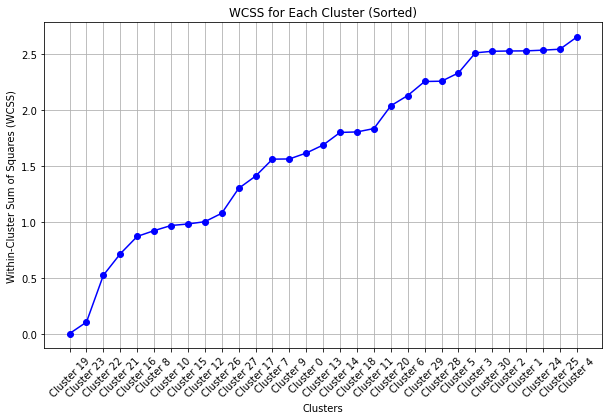

Cohesion per cluster: {0: 0.19303369054012406, 1: 0.1576828746638784, 2: 0.15800467946470273, 3: 0.16354374167521019, 4: 0.11652459656550775, 5: 0.22330252976451384, 6: 0.2906403823765242, 7: 0.22044351921876906, 8: 0.07987571334798854, 9: 0.2195502699882501, 10: 0.03409224497087178, 11: 0.0837391771746077, 12: 0.0, 13: 0.15706084508443657, 14: 0.10100804016753757, 15: 0.020359575451720405, 16: 0.13164114822204248, 17: 0.29626004875869366, 18: 0.09873451762189404, 19: 1.0, 20: 0.32124474334485564, 21: 0.7622464837298907, 22: 0.8262026759806629, 23: 0.9657846134620561, 24: 0.1555174249837105, 25: 0.15267885357258099, 26: 0.6414638555940709, 27: 0.5673419308347009, 28: 0.2480362965465028, 29: 0.24888890597483823, 30: 0.1588640210535188}


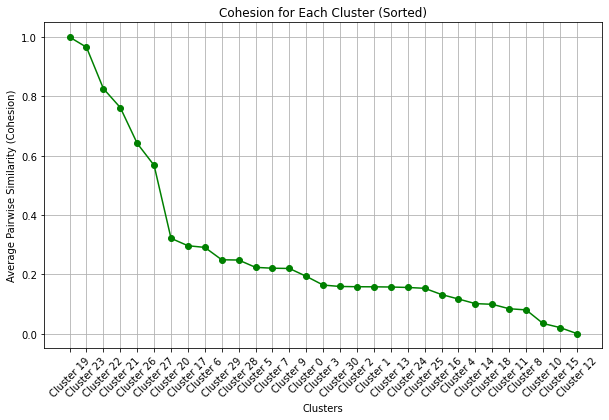

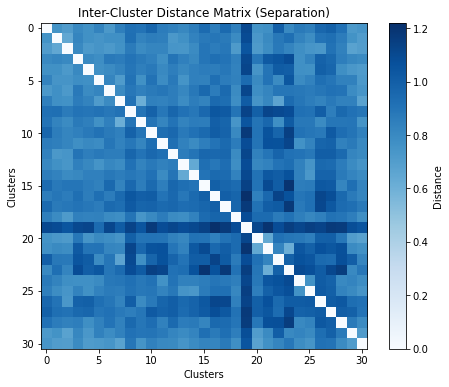

Overall Average Pairwise Similarity: 0.31544481423802995


In [20]:
embeddings_np = np.array(embeddings)
# Calculate WCSS and plot
wcss_per_cluster = within_cluster_sum_of_squares(embeddings_np, clusters)
print("WCSS per cluster:", wcss_per_cluster)
plot_wcss(wcss_per_cluster)


# Calculate Cohesion and plot
cohesion_per_cluster = average_pairwise_similarity(embeddings, clusters)
print("Cohesion per cluster:", cohesion_per_cluster)
plot_cohesion(cohesion_per_cluster)

# Calculate Inter-Cluster Distance (Separation) and plot
separation_matrix = inter_cluster_distance(embeddings, clusters)
# print("Inter-Cluster Distance Matrix:\n", separation_matrix)
plot_separation(separation_matrix)

# Calculate Overall Average Pairwise Similarity
overall_similarity = overall_average_pairwise_similarity(embeddings, clusters)
print("Overall Average Pairwise Similarity:", overall_similarity)